# Under the Hood: Training a Digit Classifier

In this notebook I'll step through the process of training a very basic neural network digit classifier on the full mnist dataset using fastai. This task was the 'exam question' set at the end of Chapter 4 of the Deep Learning for Coders course where we began by training a digit classifier to differentiate images of '3's and '7's. 

I wanted to have a go at this as I've never really gone under the hood and put the work into understanding how all the individual steps of training a neural network hang together. Crucially I have little intuition of why neural networks work so well in a mathematical sense even though I have studied linear algebra within an engineering context and applied AI within my day job for nearly two years. Whilst I am very familiar with much of the underlying maths, I still find the results of the process to be counter-intuitive. Its like a group of concepts than when taught well in isolation are very straightforward but when coupled remain slippery and surprising. Whenever I have tried to read deeper, I am greeted with unappealling looking formulas and ridiculously complicated sounding techniques that coupled together make deep learning kind-of unappealing to delve deeper. Furthmore, I can succesfully train a decent object detection model with several lines of PyTorch/Tensorflow and improve my model through following articles detailing higher level concepts- so why go deeper? Why go deep into training a simple model to do something boring like tell digits apart when I'm usually more interested in novel applications and creative computing? 

Well, in this case I've really enjoyed Deep Learning for Coders and found Jeremy to be excellent company. I also loved listening to a discussion Bruce Sterling recently had with Matt Dryhurst and Holly Herndon around AI art where Sterling suggested the most interesting aspect of this field is less the resultant artefact (some sculpture or GAN art) but more what's going on within the network as we train, likening it to kinetic art. There is movement and dance going on as we train and following his useful critique I have a renewed interest to understand the dynamics and cartography of this process. Here is my mental mapping of that process.

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

Fastai makes it very straightword to download MNIST alongside a load of other useful ML datasets. For the full dataset, folders are split into training (60,000 images) and testing (10,000 images). Each of those folders containers further folders named after the 10 different labels used within the dataset (numbers from 0-9).    

In [3]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

In [4]:
images = 0
for root, dirs, files in os.walk(path):
    images += len(files)
images

70000

We can easily access the images by storing lists of files within relevant variables.

In [5]:
zeros = (path/'training'/'0').ls().sorted()
ones = (path/'training'/'1').ls().sorted()
twos = (path/'training'/'2').ls().sorted()
threes = (path/'training'/'3').ls().sorted()
fours = (path/'training'/'4').ls().sorted()
fives = (path/'training'/'5').ls().sorted()
sixes = (path/'training'/'6').ls().sorted()
sevens = (path/'training'/'7').ls().sorted()
eights = (path/'training'/'8').ls().sorted()
nines = (path/'training'/'9').ls().sorted()

We can use Python Imaging Library's Image class to open an example image: 

In [6]:
first_zero = Image.open(zeros[0])

Images are just represented as numbers within a computer, usually between values 0-255. We're working with grayscale images here so rather than requiring 3 or 4 values to describe each pixel, its just one value. To begin working with our images we pass them to our tensor function which will return a PyTorch tensor, a matrix similar to Numpy arrays although with some essential differences for deep learning. The image is stored within a tensor of shape 28,28. So 28 rows of 28 elements. The tensor has two dimensions so we say it has rank 2. 

In [7]:
first_tensor = tensor(first_zero)
# portion of tensor
first_tensor[0:25, 5:25]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  54, 227, 253, 252, 239, 233, 252,  57,   6,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,  10,  60, 224, 252, 253, 252, 202,  84, 252, 253, 122,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 163, 252, 252, 252, 253, 252, 252,  96, 189, 253, 167,   0,   0,   0],
        [ 

In [8]:
# tensor rank 
first_tensor.ndim

2

We can use this nice background feature within Pandas to visualise our image and values in better detail. 

In [9]:
df = pd.DataFrame(first_tensor[0:25, 5:25])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,51,159,253,159,50,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,48,238,252,252,252,237,0,0,0,0,0
6,0,0,0,0,0,0,0,0,54,227,253,252,239,233,252,57,6,0,0,0
7,0,0,0,0,0,0,10,60,224,252,253,252,202,84,252,253,122,0,0,0
8,0,0,0,0,0,0,163,252,252,252,253,252,252,96,189,253,167,0,0,0
9,0,0,0,0,0,51,238,253,253,190,114,253,228,47,79,255,168,0,0,0


## First Try: Pixel Similarity

Before we build our fancy neural network model we should begin by creating a simple baseline model with which we can access the performance of any subsequent models. This baseline should be simple to implement and test. 

For a baseline model we will first find the average pixel value for every pixel across all images within each digit class. This will give us ten tensors containing average pixel values, defining what we might call the "ideal" image for each digit class or the average image for each class. Then, to classify a new image, we see which of our average images our new image is most similar to. This is simplistic so should make a good baseline.

First step is creating our average image for each class. We'll do this by stacking all our images for each class within a set of tensors. This can take a while, so maybe time to make tea. 

In [10]:
zero_tensors = [tensor(Image.open(o)) for o in zeros]
print('zero')
one_tensors = [tensor(Image.open(o)) for o in ones]
print('one')
two_tensors = [tensor(Image.open(o)) for o in twos]
print('two')
three_tensors = [tensor(Image.open(o)) for o in threes]
print('three')
four_tensors = [tensor(Image.open(o)) for o in fours]
print('four')
five_tensors = [tensor(Image.open(o)) for o in fives]
print('five')
six_tensors = [tensor(Image.open(o)) for o in sixes]
print('six')
seven_tensors = [tensor(Image.open(o)) for o in sevens]
print('seven')
eight_tensors = [tensor(Image.open(o)) for o in eights]
print('eight')
nine_tensors = [tensor(Image.open(o)) for o in nines]
print('nine')
len(three_tensors),len(seven_tensors), len(nine_tensors)

zero
one
two
three
four
five
six
seven
eight
nine


(6131, 6265, 5949)

In [11]:
tensors = [zero_tensors, one_tensors, two_tensors, three_tensors, four_tensors, five_tensors, six_tensors, seven_tensors, eight_tensors, nine_tensors]

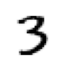

In [12]:
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor. We often need to stack up individual tensors in a collection into a single tensor, like a really tall thin skyscraper. Unsurprisingly, PyTorch comes with a function called stack that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to cast our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to float now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally in Computer Vision when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here.

In [13]:
stacked_zeros = torch.stack(zero_tensors).float()/255
stacked_ones = torch.stack(one_tensors).float()/255
stacked_twos = torch.stack(two_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_fours = torch.stack(four_tensors).float()/255
stacked_fives = torch.stack(five_tensors).float()/255
stacked_sixes = torch.stack(six_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_eights = torch.stack(eight_tensors).float()/255
stacked_nines = torch.stack(nine_tensors).float()/255

We can compute what our ideal digits looks like by taking the mean along dimension 0 of each stacked, rank-3 tensor. This is the dimension that indexes over all the images.

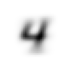

In [14]:
mean0 = stacked_zeros.mean(0)
mean1 = stacked_ones.mean(0)
mean2 = stacked_twos.mean(0)
mean3 = stacked_threes.mean(0)
mean4 = stacked_fours.mean(0)
mean5 = stacked_fives.mean(0)
mean6 = stacked_sixes.mean(0)
mean7 = stacked_sevens.mean(0)
mean8 = stacked_eights.mean(0)
mean9 = stacked_nines.mean(0)
show_image(mean4);

Taking the mean of a stack of tensors representing images can be quite interesting. I tried this for a dataset of bears. From this we can deduce the likely position and colour of our average bear as well as the presence of green foliage around the bear. Its quite a nice foggy aesthetic and I would be curious to explore this technique further.

![title](images/average_bear.png)

In [15]:
# silly example
# pix = Path('bears/black').ls().sorted()
# bears = [tensor(Image.open(bear).resize((300,300)).convert('RGB')) for bear in pix]
# stacked_bears = torch.stack(bears).float()/255
# meanBear = stacked_bears.mean(0)
# show_image(meanBear)

Now we've created our mean images lets find the similarity between our mean and a new image by calculating the distance between them. To do this we use two methods, RMSE (root mean squared error) and L1 norm (absolute difference value) for calculating distance between sets of values where directionality is ignored (ie whether difference is a positive or negative number). We use these methods because we want to calculate the magnitude of distance between values and the squared terms remove directionality. Both approaches are valid for this problem although if we're getting into it, MSE differs in that it will penalize bigger mistakes more heavily than L1 although it will be more lenient with small mistakes. We manually implement these methods here: 

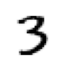

In [16]:
# new image
a_3 = stacked_threes[1]
show_image(a_3);

In [17]:
# compare an image of 3 to our mean 3
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [18]:
# compare an image of 3 to our mean 7 
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

PyTorch includes both these functions as 'loss functions' ie methods for calculating the magnitude of the difference or 'distance' between our expected result and our predicted result as a single number. 

In [19]:
# l1 norm is the absolute value of differences 
# mse - mean squared error
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays vs PyTorch Tensors (aside)

Before we go further, why are we using PyTorch tensors rather than Numpy arrays? 

So PyTorch tensors and Numpy arrays have very similar APIs although key differences are, Numpy doesn't support using the GPU or calculating gradients. These are two things we really need for deep learning. It would basically be impossible to do deep learning without these capabilities.

PyTorch tensors can live on the GPU where their computation is optimized for the GPU and as such runs a lot faster given enough values to work with. Most importantly we can automatically calculate derivatives of our operations (gradients) and also combinations of operations. 

Python is slow, but Numpy and PyTorch are much faster. However for performing algebriac operations on matrices, PyTorch demonstrates far superior performance.

In [20]:
# PyTorch 
x = torch.rand(10000, 10000)
y = torch.rand(10000, 10000)

current_time = time.time()

a = x + y
b = x - y
c = x * y

end_time = time.time()
end_time - current_time

0.13687992095947266

In [21]:
# Numpy
x = np.random.rand(10000, 10000)
y = np.random.rand(10000, 10000)

current_time = time.time()

a = x + y
b = x - y
c = x * y

end_time = time.time()
end_time - current_time

1.6655244827270508

## Computing Metrics Using Broadcasting

Metrics are human-friendly numbers that tell us how well our model is performing (ie accuracy of 73% rather than something less friendly like RMSE=0.1586). We calculate metrics based on the data our model has not seen to avoid overfitting. That data sits in testing so lets extract it now: 

In [22]:
valid_0_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'0').ls()])
valid_0_tens = valid_0_tens.float()/255
valid_1_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'1').ls()])
valid_1_tens = valid_1_tens.float()/255
valid_2_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'2').ls()])
valid_2_tens = valid_2_tens.float()/255
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_4_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'4').ls()])
valid_4_tens = valid_4_tens.float()/255
valid_5_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'5').ls()])
valid_5_tens = valid_5_tens.float()/255
valid_6_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'6').ls()])
valid_6_tens = valid_6_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_8_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'8').ls()])
valid_8_tens = valid_8_tens.float()/255
valid_9_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'testing'/'9').ls()])
valid_9_tens = valid_9_tens.float()/255

We can check our tensor's shape to check all is well. As we expect we see 1010 images of shape 28x28 have been stacked.

In [23]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

What we want to do now is to calculate distance between an image within a validation tensor with a mean image to determine the distance between them. 

To do this, we first subtract both tensors, take absolute value of the resulting tensor of difference values and then sum all values to get the mean pixel distance between both tensors as described within the below function: 

In [24]:
def mnist_distance(a,b): return (a-b).abs().mean()

Lets try it out with our example image (a_3) and all of the mean images to find which it is closest to:

In [25]:
means = [mean0, mean1, mean2, mean3, mean4, mean5, mean6, mean7, mean8, mean9]

In [26]:
# distance between image of a 3 and average 0 image:
distance = mnist_distance(a_3, mean0)
distance

tensor(0.1879)

In [27]:
def what_is(image):
    similar_mean = 0
    distance = mnist_distance(image, mean0)
    for i in range(len(means)):
        if mnist_distance(image, means[i]) < distance:
            similar_mean = i
            distance = mnist_distance(image, means[i])
    print('most similar image: ' + str(similar_mean))      

Give it a go with a range of tensors ie one_tensors[2] or seven_tensors[8]. If you play with it enough you'll realise it works ok but its by no means perfect! 

In [28]:
what_is(seven_tensors[8])

most similar image: 7


However, what if we wanted to calculate the accuracy of the model against the thousands of images within each class? 
For this we would usually have to loop through all the images within each class, passing them to the function one by 
one and then stacking the results in a tensor to calculate the accuracy. We would be calculating distance between our mean tensor of rank 2 and each rank 2 tensor within our rank 3 tensor containing all of the images for each class. However looping through all these images is inefficient and Python has a really nice feature called broadcasting that we can exploit to perform operations on matrices of different rank. 

Broadcasting works as follows: if we are performing operations on two matrices of different rank, Python automatically expand the tensor of smaller rank to have the same size as the larger tensor and allow us to easily perform our operation. This works great here in that we can instantly calculate the prediction for each image within our larger validation tensors without looping! The only thing we need to add to our function is a specification of what tensor dimensions we want to calculate our mean value as we are now working with a rank 3 tensor rather than rank 2 and PyTorch just stores the data as numbers in memory- the framework doesn't recognise the tensor as a stack of images, just a tensor of numbers. 

In [29]:
# redefine our function
def mnist_distance(a,b): return ((a-b).abs()).mean((-1,-2))

In [30]:
means = [mean0, mean1, mean2, mean3, mean4, mean5, mean6, mean7, mean8, mean9]
validations = [valid_0_tens, valid_1_tens, valid_2_tens, valid_3_tens, valid_4_tens, valid_5_tens, valid_6_tens, valid_7_tens, valid_8_tens, valid_9_tens]

In [31]:
def mean_predictions(x, label): 
    previous_distance = mnist_distance(x, mean0)
    previous_predictions = torch.zeros([len(x)]).int()
    for j in range(len(means[1:])): 
        current_distance = mnist_distance(x, means[j+1])
        previous_predictions = torch.where(current_distance < previous_distance, tensor(j+1).int(), previous_predictions)
        previous_distance = torch.where(current_distance < previous_distance, current_distance, previous_distance)
    histogram = torch.histc(previous_predictions.float(), bins=10, min=0, max=9)
    mode_value = torch.argmax(histogram).item()
    correct_predictions = histogram[label].int().item()
    accuracy = histogram[label].int().item()/len(x)
    print("predicted class: " + str(mode_value) + ", accuracy: " + str(accuracy))
    return histogram, correct_predictions

We can use this function to plot histograms of all our models predictions for each validation set. We notice that 1's are classified with best accuracy by far. This feels intuitive as 1 is likely to be the most simple digit representing a line... zeros are great, however other classes perform more poorly. 

In [32]:
# torch.histc(mean_predictions(valid_0_tens))
h, c = mean_predictions(valid_0_tens, 0)

predicted class: 0, accuracy: 0.8153061224489796


The overall accuracy of our model across the complete validation dataset is 66.85%. 

In [33]:
correct_predictions = 0 
length = 0
for i in range(len(validations)):
    h,c = mean_predictions(validations[i], i)
    correct_predictions += c
    length += len(validations[i])
print("model accuracy: " + str(correct_predictions/length)) 

predicted class: 0, accuracy: 0.8153061224489796
predicted class: 1, accuracy: 0.9982378854625551
predicted class: 1, accuracy: 0.42344961240310075
predicted class: 3, accuracy: 0.6089108910891089
predicted class: 4, accuracy: 0.6680244399185336
predicted class: 1, accuracy: 0.32623318385650224
predicted class: 6, accuracy: 0.7870563674321504
predicted class: 7, accuracy: 0.7645914396887159
predicted class: 8, accuracy: 0.44250513347022585
predicted class: 9, accuracy: 0.77601585728444
model accuracy: 0.6685


## Stochastic Gradient Descent (SGD)

So how do we improve our model? We need to have some way of testing the effectiveness of our current weights in terms of performance and implementing a way of adjusting weights to maximise performance (in Arthur Samuel's words). This is how our model will get better and better. 

We're missing two things: a kind of weight assignment and a way of improving our weights by testing them.

So lets first of all give each pixel within our images a set of weights (w) such that when we multiply our pixels with these weights, larger weights are associated with pixels more likely to be black for our particular category. This is kindof similar to what we saw previously with pixel similarity where we expect less distance when the pixels we are comparing are similar- only here we're inverting this and saying we want to return higher values when pixels are more likely to correspond to the class the image they belong to sits within. We can express this as a function that we expect to return relatively larger values when provided with an image (x) corresponding to the class it belongs to. ie we want this function to return highest value when x is an image of an 8.

def probability_image_is_an_eight(x,w) = (x*w).sum()

So to actually improve our weights tensor (w) such that it returns high value and allows us to differentiate our images to a fantastic level of accuracy (relative to our baseline) we need to follow the following 7 steps that underpin all training of deep learning models. 

1. initialize weights - here we usually start with random values unless we are transfer learning then we start with some pretrained weights. 
2. use weights to predict image class
3. calculate how good our model is in terms of loss - remember loss needs to decrease when our network's performance improves and it also needs to be sensitive enought to change when individual weights are altered such that we can calculate the gradient of our weights and understand the outcome of altering that weight assignment on the model performance
4. calculate the gradient for each of the many many weights in our network (how loss changes relative to change in JUST THAT SINGLE WEIGHT)
5. change all the weights based on our gradient calculations (this is called our Step)
6. Go back to step 2 and repeat the whole process
7. Iterate until we're happy

### Calculating Gradients

This can be a little confusing at first in terms of syntax but its actually really powerful. We can easily calculate the gradient of our tensors by using the require_grad method. 

For instance: 
xt = tensor(3.).requires_grad_()

In [34]:
# pretend this is our loss function and x is our weight 
# we want to work out the impact of adjusting our weight on the loss function
def f(x): return x**2

The weight we are investigating has the value 3 and we want to figure out whether we should increase or descrease it. We have to calculate the gradient first to figure our what action will decrease our loss. We use the requires_grad method to specify that we want to calculate the gradient of this weight. Gradient usually means the slope in maths but here we mean a value ie gradient = -0.5

In [35]:
weight = tensor(3.).requires_grad_()

In [36]:
loss = f(weight)
loss

tensor(9., grad_fn=<PowBackward0>)

So loss = 9 ... how do we reduce this? First we need to calculate the gradient. In deep learning we have a fancy complicated word for this: we need to 'backpropogate' ie for each layer of our neural network, calculate the gradient for each weight, or in simpler terms, how much will our loss change when we change our weight by a certain amount (whilst keeping all other weights constant)? Lets backpropagate! 

In [37]:
loss.backward()

Now lets check the gradient for our particular weight assignment.

In [38]:
weight.grad

tensor(6.)

As expected, its the derivate of x^2, 2x with our value 3 subbed in for x. Its incredibly simple. The syntax may be confusing at first but its doing something very basic over and over again. Importantly we can do this for whole tensors of values using PyTorch. So now lets step and use the learning parameter to adjust our weight value. There is a lot to say about learning rate but for now, if we go to small it will take forever to train our model and we can stuck within local minima. If we go too high with our learning rate it will bounce around without ever diverging. There are techniques for mitigating this but that's a whole other topic.  

In [39]:
lr = 0.01
weight.data -= lr*weight.grad.data
weight

tensor(2.9400, requires_grad=True)

In [40]:
f(weight)

tensor(8.6436, grad_fn=<PowBackward0>)

We've successfully reduced our loss by 0.367!

## The MNIST Loss Function

Now we'll attempt to write a classifier for full MNIST. 

First we'll store all of our training images within a single tensor and change them from a list of matrices to a rank 2 tensor. So basically stacking 60,000 flattened (1D) images on top of eachother. 

In [41]:
train_x = torch.cat([stacked_zeros, stacked_ones, stacked_twos, stacked_threes, stacked_fours, stacked_fives, stacked_sixes, stacked_sevens, stacked_eights, stacked_nines]).view(-1, 28*28)

In [42]:
train_x.shape

torch.Size([60000, 784])

We now create a similar tensor containing all of the labels for each image within our 
training dataset. We want to classify our images as one of 10 digits. So our classifiers output should communicate one of 10 numbers. Therefore we are trying to reduce an 28x28 shaped tensor representing our image to a single number representing each class. Its tempting to initially think we should use the label as the classification output ie all zero images should be labelled as tensor(0). However this approach would not allow us to calculate the propabilities our image belongs to each class because its only outputting one number between 0-9. What would be better would be an output of 10 numbers with each indicating the probability that the input image belongs to the corresponding class. For example a zero image should return: 

tensor([1,0,0,0,0,0,0,0,0,0]) 

This approach to labelling is called One-Hot Encoding and is the approach we'll take here. Its also standard for multi-class classification. 

In [43]:
train_y = tensor([[1,0,0,0,0,0,0,0,0,0]]*len(zeros)+ 
           [[0,1,0,0,0,0,0,0,0,0]]*len(ones)+ 
           [[0,0,1,0,0,0,0,0,0,0]]*len(twos)+
           [[0,0,0,1,0,0,0,0,0,0]]*len(threes)+
           [[0,0,0,0,1,0,0,0,0,0]]*len(fours)+
           [[0,0,0,0,0,1,0,0,0,0]]*len(fives)+
           [[0,0,0,0,0,0,1,0,0,0]]*len(sixes)+
           [[0,0,0,0,0,0,0,1,0,0]]*len(sevens)+
           [[0,0,0,0,0,0,0,0,1,0]]*len(eights)+
           [[0,0,0,0,0,0,0,0,0,1]]*len(nines)
          )

In [44]:
# example zero image label: 
train_y[0]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

PyTorch requires us to create a Dataset to return a tuple of (x,y)

In [45]:
dset = list(zip(train_x,train_y))

In [46]:
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

Now we can create a DataLoader from our dataset which will pass our model our data in batches. We use batches because we need to periodically calculate loss on our dataset as we train. One image wouldn't provide us with much useful information (provide a very unstable and imprecise gradient) and our whole dataset would take forever so we compromise and choose a number in between to calculate our average loss across some images. Batch size impacts speed and accuracy of training and picking a good one is a hot topic. 

In [249]:
dl = DataLoader(dset, batch_size=1024, shuffle=True)
xb,yb = first(dl)
xb.shape,yb.shape
# first mini batch containes our images (256 rows, 784 long (28x28 flattened image)) and labels (265)

(torch.Size([1024, 784]), torch.Size([1024, 10]))

Lets repeat this process for our validation set. 

In [48]:
validations = [valid_0_tens, valid_1_tens, valid_2_tens, valid_3_tens, valid_4_tens, valid_5_tens, valid_6_tens, valid_7_tens, valid_8_tens, valid_9_tens]

In [49]:
valid_x = torch.cat(validations).view(-1, 28*28)

In [50]:
valid_y = tensor([[1,0,0,0,0,0,0,0,0,0]]*len(valid_0_tens)+ 
           [[0,1,0,0,0,0,0,0,0,0]]*len(valid_1_tens)+ 
           [[0,0,1,0,0,0,0,0,0,0]]*len(valid_2_tens)+
           [[0,0,0,1,0,0,0,0,0,0]]*len(valid_3_tens)+
           [[0,0,0,0,1,0,0,0,0,0]]*len(valid_4_tens)+
           [[0,0,0,0,0,1,0,0,0,0]]*len(valid_5_tens)+
           [[0,0,0,0,0,0,1,0,0,0]]*len(valid_6_tens)+
           [[0,0,0,0,0,0,0,1,0,0]]*len(valid_7_tens)+
           [[0,0,0,0,0,0,0,0,1,0]]*len(valid_8_tens)+
           [[0,0,0,0,0,0,0,0,0,1]]*len(valid_9_tens))

valid_dset = list(zip(valid_x,valid_y))

valid_dl = DataLoader(valid_dset, batch_size=10000, shuffle=True)

1) INITIALIZE

First we need a function to initialize our weights:

In [51]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

For our weights we'll use the most basic possible configuration for the problem - 10 28x28 tensors to reduce our input image to a 10x1 shape tensor. 

In [52]:
weights = init_params((10,28*28))

We also need to add a bias term as we encounter 0 gradients when working with 0 pixels for any value of weights. This is very unflexible abd will hinder our progress in improving our model. So a random bias tensor can help.  

In [53]:
bias = init_params(10,1)

In [54]:
weights.shape, bias.shape

(torch.Size([10, 784]), torch.Size([10]))

2) PREDICT 

Here we define our linear model. Our simple model multiplies all our images by our weights and add bias term to return a prediction. 

In [55]:
def linear1(xb): return xb@weights.T + bias

So it returns an array of random numbers which we can then use to calculate loss. Lets define a loss function. We can see our predictions have a wide range of values and we're looking to compare them with our label tensors which lie within the probability range of 0-1 and also sum to 1 so we need to transform our predictions to this format. We can apply PyTorch's softmax function to transform our predictions into a tensor of this form that we can use to calculate loss.

However now we need to figure out the best way of calculating loss! I tried one way initially similar to how we improve a model with binary classification. However it wasn't super successful and never really trained a model beyond 65% accuracy. For lower learning rates it would often get stuck. From the literature around multi-class classification, it seems cross-entropy loss is standard so I found a nice friendly article explaning how to implement it and replicated here. It trained a significantly more accurate model! But feel free to sub either loss to see the difference a suitable loss function can make. 

In [56]:
# rubbish loss function 
def mnist_loss(predictions, targets): 
    predictions = predictions.softmax(dim=1)
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [57]:
# superior loss function 
def cross_entropy_loss(predictions, targets):
    predictions = predictions.softmax(dim=1)
    cross = -(targets)*torch.log(predictions)
    return cross.mean()

We can test our loss function to see the output. 

In [134]:
test_predictions = linear1(train_x[:4])
test_targets = train_y[:4]
cross_entropy_loss(test_predictions, test_targets)

tensor(0.0001, grad_fn=<MeanBackward0>)

Next we create a function to calculate our gradient for each weight. 

In [59]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = cross_entropy_loss(preds, yb)
    loss.backward()

Now our training process:

    - loop through our dataloader grabbing our batch
    
    - calculate the gradient for each weight
    
    - update our parameters
    
    - set our gradients to zero before the next loop

In [60]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

Now we want to see how our accuracy changes with each epoch so we define a function to return accuracy on our validation set following each epoch. 

In [61]:
def batch_accuracy(xb, yb):
    preds = xb.softmax(dim=1).round()
    correct = preds.max(1).indices == yb.max(1).indices
    return correct.float().mean()

In [62]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

Set our learning rate, pass weights and biases and calculate our initial accuracy following randomising weights: 

In [63]:
# initial accuracy: 
lr = 2.
params = weights,bias
validate_epoch(linear1)

0.088

Train our network for one epoch and evaluate: 

In [64]:
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4613

Train for more epochs! We should see our model reaching over 80% accuracy which is significantly better than our baseline.  

In [65]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6146 0.6851 0.7253 0.7501 0.77 0.7835 0.7956 0.8044 0.8113 0.8174 0.8219 0.827 0.8303 0.8336 0.837 0.8392 0.8428 0.8442 0.8463 0.8492 

### Creating an Optimizer

However we don't have to handcode our loss function or one-hot encoding, PyTorch does a lot of this for us.
Firstly instead of writing linear1 and init_params, we can do this in one step: 

In [66]:
# instead of linear1() and init
linear_model = nn.Linear(28*28,10)

In [67]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([10, 784]), torch.Size([10]))

In [68]:
# optimiser for optimising our parameters 
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr
    
    # goes through each parameter making a change 
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
# zeros each parameter out 
            # why do we need zero gradient again? 
# we don't want to calculate the gradient on our step once we've made it
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None
            
# exact same code we;ve seen before 

In [69]:
# pass in our parameters 
opt = BasicOptim(linear_model.parameters(), lr)

In [70]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [71]:
validate_epoch(linear_model)

0.098

In [72]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

We also see really nice results here too. 

In [73]:
train_model(linear_model, 10)

0.7505 0.8202 0.842 0.8561 0.8623 0.8685 0.8744 0.8775 0.8803 0.8839 

fastai provides SGD class which does the same thing as BasicOptim: 

In [74]:
linear_model = nn.Linear(28*28,10)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.7499 0.8196 0.8427 0.8554 0.8633 0.8689 0.8743 0.8785 0.8809 0.883 0.8859 0.8866 0.8883 0.8893 0.8913 0.8917 0.893 0.8935 0.8953 0.8957 

We can also use Learner.fit instead of train_model.

In [75]:
dls = DataLoaders(dl, valid_dl)

In [78]:
lr = 1. 

In [79]:
# C - train model using Learner instead of train_model
learn = Learner(dls, nn.Linear(28*28,10), opt_func=SGD,
                loss_func=cross_entropy_loss, metrics=batch_accuracy)

In [80]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.105014,0.071992,0.626800,00:01
1,0.072970,0.055114,0.751800,00:01
2,0.058957,0.048386,0.795500,00:01
3,0.051512,0.044570,0.819300,00:01
4,0.047177,0.042114,0.832000,00:01
5,0.044453,0.040342,0.841200,00:01
6,0.042459,0.038911,0.848500,00:01
7,0.040959,0.037825,0.855200,00:01
8,0.039867,0.036926,0.859300,00:00
9,0.038928,0.036207,0.863400,00:00


## Adding a Nonlinearity

This is a really simple neural network we've created. It has one hidden layer, one softmax layer and an output layer. Softmax is the non-linear layer that allows us to approximate any function. Key point is that if we are stacking linear functions, we can only approximate linear functions. If we include non-linear we can approximate any function! SGD is helping us find the right values for weights and bias that allow us to do this. 

And this is basically all there is to it! 

However we can use Pytorch and fastai to write out our NN in more neural net friendly terms. We previously had our softmax layer within our batch accuracy function and our cross entropy so we can remove it from them by writing new ones and including our softmax layer within our network definition: 

In [ ]:
#### superior loss function 
def new_cross_entropy(predictions, targets):
#     predictions = predictions.softmax(dim=1)
    cross = -(targets)*torch.log(predictions)
    return cross.mean()

def new_batch_accuracy(xb, yb):
    preds = xb.round()
    correct = preds.max(1).indices == yb.max(1).indices
    return correct.float().mean()

simple_net = nn.Sequential(
    nn.Linear(28*28,10),
    nn.Softmax(dim=1)
)

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=new_cross_entropy, metrics=new_batch_accuracy)

learn.fit(20,1.)

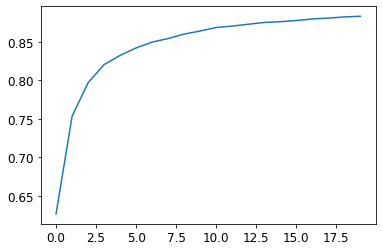

In [356]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [357]:
learn.recorder.values[-1][2]

0.8834999799728394

In [ ]:
m = learn.model

# super cool function - we can look inside the network: 
w, b = m[0].parameters()

# see what our different layers look like 
show_image(w[9].view(28,28))

We can use the inbuilt CrossEntropyLoss however, this will require our different to be slighly different. Rather than providing one-hot encoded, the target should be in the form of a 1 dimentional tensor containing the expected value! So we will have to do some data re-processing first. 

In [354]:
# Adjust our loss function ... 
# comparrison of loss methods 
criterion = nn.CrossEntropyLoss()

print((linear1(train_x[0:3])).unsqueeze(0).shape)
print(train_y[0:3].shape)
loss = criterion(linear1(train_x[1500:2000]), train_y[1500:2000].max(1).indices)
new_cross = new_cross_entropy(linear1(train_x[1500:2000]).softmax(dim=1), train_y[1500:2000])
print("loss: " + str(loss) + ", new_cross: " + str(new_cross))

torch.Size([1, 3, 10])
torch.Size([3, 10])
loss: tensor(0.3791, grad_fn=<NllLossBackward>), new_cross: tensor(0.0379, grad_fn=<MeanBackward0>)


In [298]:
alt_train_y = train_y.max(1).indices
alt_valid_y = valid_y.max(1).indices

In [299]:
alt_dset = list(zip(train_x,alt_train_y))
alt_valid_dset = list(zip(train_x,alt_valid_y))

In [300]:
alt_dl = DataLoader(alt_dset, batch_size=1024, shuffle=True)
alt_valid_dl = DataLoader(alt_valid_dset, batch_size=1024, shuffle=True)

In [301]:
alt_dls = DataLoaders(alt_dl, alt_valid_dl)

In [302]:
xc,yc = first(alt_dl)
xc[0:4].shape,yc[0:4]

(torch.Size([4, 784]), tensor([5, 2, 1, 3]))

In [344]:
def alt_batch_accuracy(xb, yb):
    preds = xb.round().max(1).indices
#     print(preds)
    correct = preds == yb
    return correct.float().mean()

In [350]:
alt_simple_net = nn.Sequential(
    nn.Linear(28*28,10),
    nn.Softmax(dim=1)
#     nn.Linear(10,1)
)

In [351]:
alt_learn = Learner(alt_dls, simple_net, opt_func=SGD,
                loss_func=F.cross_entropy, metrics=alt_batch_accuracy)
alt_learn.fit(10,1.)

epoch,train_loss,valid_loss,alt_batch_accuracy,time
0,1.846877,2.353982,0.096400,00:01
1,1.730482,2.355823,0.096400,00:01
2,1.667508,2.357436,0.096600,00:01
3,1.634613,2.358516,0.096400,00:01
4,1.616899,2.359740,0.096700,00:01
5,1.605950,2.359615,0.096200,00:01
6,1.598337,2.360358,0.096500,00:01
7,1.593067,2.360717,0.095700,00:01
8,1.589037,2.360890,0.096100,00:01
9,1.585888,2.361422,0.096100,00:01


### Going Deeper

In [681]:
# using all the tricks, you can fit for one epoch and train to 97% accuracy in single epoch 
# dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False, n_out=10,
                    loss_func=F.cross_entropy, metrics=batch_accuracy)
learn.fit_one_cycle(1, 0.1)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 2-dimensional input of size [1024, 784] instead